In [1]:
import sys
print("Python version: ", sys.version)
import os
from pathlib import Path
import time
import datetime
import itertools
import random

import numpy as np
print("numpy version", np.__version__)

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version", matplotlib.__version__)

import imutils

from tqdm import tqdm
tqdm.pandas()

#from perlin_numpy import (
#    generate_perlin_noise_3d
#)

import tensorflow as tf
print("TF:", tf.__version__)

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, MaxPool2D, multiply
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.framework import ops

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

from IPython import display

import simulate
import process

Python version:  3.8.10 (default, Mar 15 2022, 12:22:08) 
[GCC 9.4.0]
numpy version 1.23.1
matplotlib version 3.5.2
TF: 2.9.1


In [2]:
DATA_PATH = "./data/"
MARKER_PATH = "./markers_official/"

## Build an input pipeline with `tf.data`

In [3]:
lstDfs = []
for f in tqdm(["16h5_validation.pkl", "36h11_training.pkl"], desc="Load files"):
    lstDfs.append(pd.read_pickle(f"{DATA_PATH}{f}"))

df = pd.concat(lstDfs)

df["Marker"] = df.progress_apply(lambda e: simulate.load_tag(e.Size, e.MarkerType, e.Id, e.Angle, MARKER_PATH=MARKER_PATH), axis=1)
df.reset_index(drop = True, inplace = True)

# create train/test/val split
df['Datatype'] = ""

np.random.seed(420)
indices = np.arange(len(df))
np.random.shuffle(indices)

train, test = .7, .3
# We do not keep a validaton set back, because we have a validation dataset with different makers.

train_len = int(np.ceil(len(indices)*train))
test_len = int(train_len + np.ceil(len(indices)*test))

train_ids = indices[:train_len] 
test_ids = indices[train_len:]

df.loc[train_ids, 'Datatype'] = 'train'
df.loc[test_ids, 'Datatype'] = 'test'


100%|██████████| 645972/645972 [02:40<00:00, 4029.16it/s]


In [4]:
class DataGenerator:
    
    def __init__(self, df, batch_size = 64, shuffle = True, cap_res=(32, 32, 1), temp_res=(128,128, 1)):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.df = df
        self.n_batches = int(np.round(len(self.df)/batch_size))
        self.cap_res = cap_res
        self.temp_res = temp_res

    def __call__(self, shuffle=True):
        
        indexes = self.df.index.values
        if self.shuffle:
            np.random.shuffle(indexes)

        for i in range(self.n_batches-1):
            batch = indexes[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for i, e in self.df.loc[batch].iterrows():

                img_A = e.Blob
                img_B = e.Marker

                # Shift Blob (img_A) and Template (img_B) using normal distribution
                # stdev = 1 -> 99.73% samples within range +- 3 around mean = 0
                for shift_axis in [0, 1]:
                    shift_amount = np.random.randint(-1,2)

                    img_A = np.roll(img_A, shift_amount, axis = shift_axis)
                    img_B = np.roll(img_B, shift_amount*4, axis = shift_axis)


                img_A = img_A.reshape([self.cap_res[0],self.cap_res[1],self.cap_res[2]])
                img_B = img_B.reshape([self.temp_res[0],self.temp_res[1],self.temp_res[2]])

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            imgs_A = tf.convert_to_tensor(imgs_A)
            imgs_B = tf.convert_to_tensor(imgs_B)

            yield imgs_B, imgs_A

In [13]:
batch_size = 128
cap_res=(32, 32, 1)
temp_res=(128, 128, 1)

gen_train = DataGenerator(df[df.Datatype == 'train'], batch_size=batch_size, cap_res = cap_res, temp_res = temp_res)
gen_val = DataGenerator(df[df.Datatype == 'test'], batch_size=batch_size, cap_res = cap_res, temp_res = temp_res)

train_dataset = tf.data.Dataset.from_generator(gen_train, 
                                         output_signature=(
                                             tf.TensorSpec(shape=(batch_size, 128,128,1), dtype=tf.float32),
         tf.TensorSpec(shape=(batch_size, 32, 32, 1), dtype=tf.float32)
         )).prefetch(tf.data.AUTOTUNE).cache().repeat()

test_dataset = tf.data.Dataset.from_generator(gen_val, 
                                         output_signature=(
                                             tf.TensorSpec(shape=(batch_size, 128,128,1), dtype=tf.float32),
         tf.TensorSpec(shape=(batch_size, 32, 32, 1), dtype=tf.float32))).prefetch(tf.data.AUTOTUNE).cache().repeat()

## Build the Generator

In [15]:
def Generator(template_shape = (128, 128, 1), channels = 1, debug = True):
    
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)
    
    def conv2d(layer_input, filters, f_size=4, bn=True):
        d = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', kernel_initializer = initializer)(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        d = MaxPool2D(padding = 'same')(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, apply_dropout=False):
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu', kernel_initializer = initializer)(u)
        if apply_dropout:
            u = Dropout(0.5)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input])
        return u

    # Image input
    d0 = tf.keras.layers.Input(shape=template_shape, name="input")

    # Downsampling
    d1 = conv2d(d0, 32, bn=False)
    d2 = conv2d(d1, 64)
    d3 = conv2d(d2, 128)
    d4 = conv2d(d3, 256)
    d5 = conv2d(d4, 512)
    u5 = deconv2d(d5, d4, 256, apply_dropout = True)
    u6 = deconv2d(u5, d3, 128)

    u7 = UpSampling2D(size=2)(u6)
    output_img = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)
    model = Model(d0, output_img, name = 'generator')
    
    if (debug):
        print(model.summary())
    return model

generator = Generator(template_shape = temp_res)
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  544         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 leaky_re_lu_11 (LeakyReLU)     (None, 128, 128, 32  0           ['conv2d_15[0][0]']              
                                )                                                         

In [16]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

## Build the Discriminator

In [17]:
def Discriminator(cap_shape = (32, 32, 1), template_shape = (128, 128, 1), debug = True):
    
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)
    
    def d_layer(layer_input, filters, f_size=4, bn=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same', kernel_initializer = initializer)(layer_input)
     
        
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
            
        #d = MaxPool2D(padding = 'same')(d)
        
        return d

    def conv2d(layer_input, filters, f_size=4, strides = 1, bn=True):
        """Layers used during downsampling"""
        d = Conv2D(filters, kernel_size=f_size, strides=strides, padding='same', kernel_initializer = initializer)(layer_input)
        d = LeakyReLU(alpha=0.2)(d)

        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d 

    img_A = tf.keras.layers.Input(shape=cap_shape, name="input_cap")
    img_B = tf.keras.layers.Input(shape=template_shape, name="input_template")
    
    # Downsampling of template
    db1 = conv2d(img_B, 16, strides = 2)
    db2 = conv2d(db1, 32, strides = 2)
    da1 = conv2d(img_A, 32, strides = 1)

    # Concatenate image and conditioning image by channels to produce input
    combined_imgs = Concatenate(axis=-1)([db2, da1])

    d1 = d_layer(combined_imgs, 64, bn=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d2, 256)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d3)

    model = Model([img_B, img_A], validity, name = 'discriminator')
    
    if (debug):
        print(model.summary())
        
    return model

discriminator = Discriminator(cap_shape = cap_res, template_shape = temp_res)
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_template (InputLayer)    [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 64, 64, 16)   272         ['input_template[0][0]']         
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)     (None, 64, 64, 16)   0           ['conv2d_23[0][0]']              
                                                                                                  
 batch_normalization_17 (BatchN  (None, 64, 64, 16)  64          ['leaky_re_lu_16[0][0

## Set Hyperparameter

In [18]:
log_dir="./logs/"
Path(log_dir).mkdir(parents=True, exist_ok=True)

start_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + start_time + '_4x4_2e-4_shift_dropout')


step_count = len(df[df.Datatype == 'train'])//batch_size
decay_steps = step_count * 30

generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4, beta_1=0.5)


checkpoint_dir = './training_checkpoints'
Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_"+ start_time)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


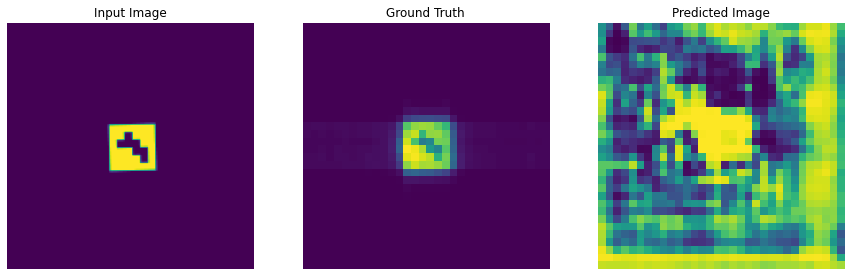

2022-07-11 19:11:48.120038: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [21]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()
        
for example_input, example_target in test_dataset.take(1).cache():
    generate_images(generator, example_input, example_target)

In [22]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        #gen_output = generator(input_image)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [24]:
datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2022-07-11 19:12:23'

Start epoch at 2022-07-11 19:12:33


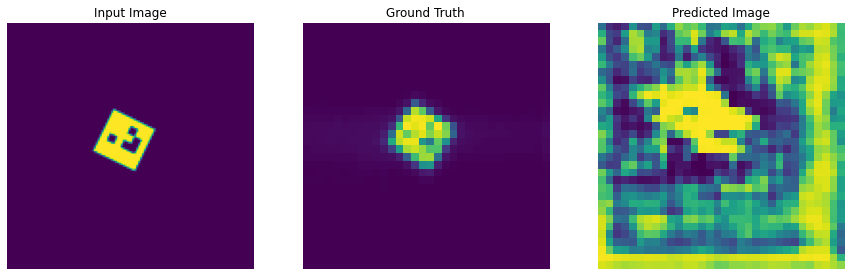

2022-07-11 19:12:34.026388: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch:  0
.

2022-07-11 19:12:34.516386: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
EPOCHS = 10
saveCheckpointAfterNEpochs = 2

for epoch in range(EPOCHS):
    start = time.time()
    display.clear_output(wait=True)

    timeSTR = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"Start epoch at {timeSTR}")
    # Display Only
    for example_input, example_target in test_dataset.take(1).cache():
        generate_images(generator, example_input, example_target)

    print("Epoch: ", epoch)

    # Training step
    for n, (input_image, target) in train_dataset.enumerate():
        print('.', end='')
        if (n+1) % 10000 == 0:
            print()
        train_step(input_image, target, epoch)
    print()

    # Test Setp
    #
    # TODO
    #

    # Saving (checkpointing) the model every 20 epochs
    if (epoch + 1) % saveCheckpointAfterNEpochs == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
print("Quality test after training")
for example_input, example_target in test_dataset.take(5):
    generate_images(generator, example_input, example_target)

Quality test after training


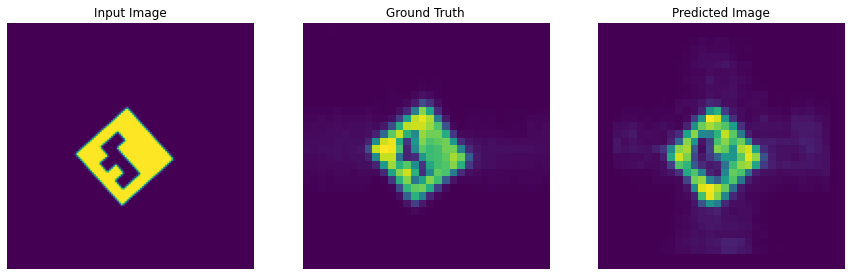

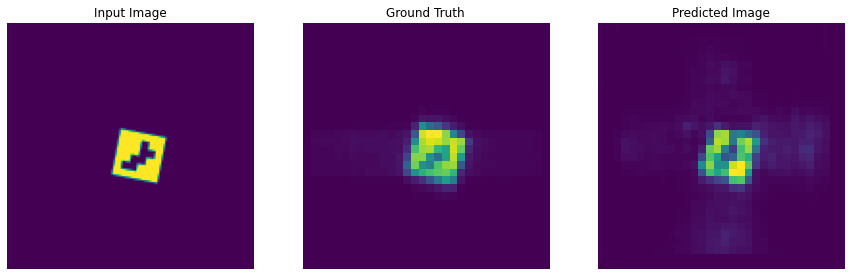

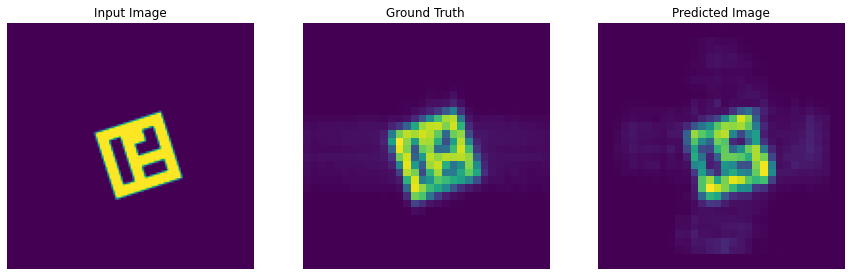

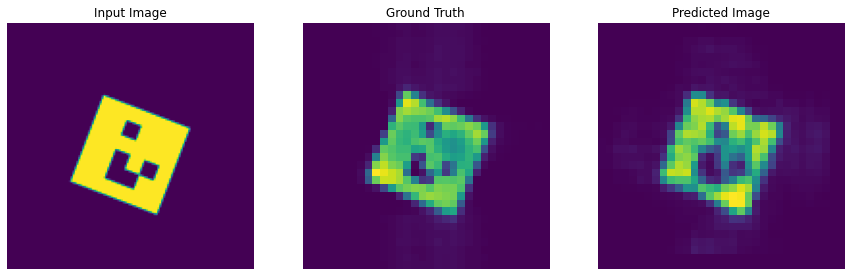

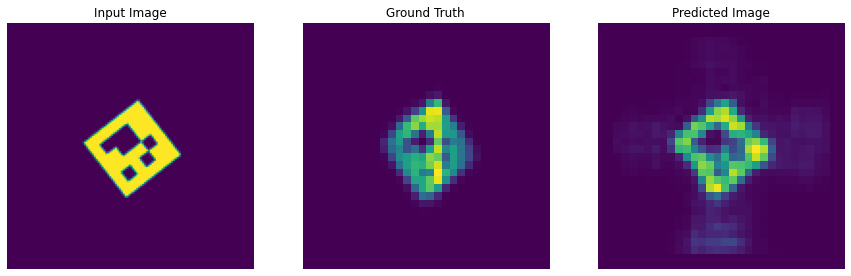

In [40]:
print("Quality test after training")
for example_input, example_target in test_dataset.take(5):
    generate_images(generator, example_input, example_target)

# Save The Last Model

In [42]:
modelSave_dir = f"./models/model_generator_{start_time}"
Path(modelSave_dir).mkdir(parents=True, exist_ok=True)
generator.save(modelSave_dir)

INFO:tensorflow:Assets written to: ./models/model_generator_2022-07-03 15:49:16/assets
